In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
#Pentru normalitate
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro 
from scipy.stats import kstest, norm
#Pentru Homoschedasticitate
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
#Pentru multicolinaritate si autocorelare
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
#Pentru autocorelare si specificare
from statsmodels.stats.diagnostic import linear_reset
#Pentru calcul metrici
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
#Clusteri
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#Lasso Ridge Elastic Net
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [2]:
def testare_homoschedasticitate(regression,actual,afiseaza_grafic=True):
    residuals = regression.resid
    exog = regression.model.exog
    print("Testul White")
    white_t = het_white(residuals,exog)
    print(white_t)
    print("Test Breuche-Pagan")
    bpt = het_breuschpagan(residuals,exog)
    print(bpt)
    if afiseaza_grafic is True:
        plt.figure(figsize=(10,8))
        plt.scatter(actual,residuals)
        plt.xlabel("Valori reale")
        plt.ylabel("Valori estimate")
        plt.title("Real vs Estimat")
        plt.show()

In [13]:
def testare_normalitate(regresie,bins,afiseaza_grafic=True):
    #Testare normalitate
    reziduuri = regresie.resid
    jb = jarque_bera(reziduuri)
    print("jarque_bera")
    print(jb)
    print("SHAPIRO")
    shapiro_test = shapiro(reziduuri)
    print(shapiro_test)
    print("Kolmogov Smirnov")
    print(kstest(reziduuri, "norm", args=(reziduuri.mean(), reziduuri.std())))
    if afiseaza_grafic is True:
        plt.figure(figsize=(10,6))
        plt.title("Distributia erorilor")
        plt.hist(reziduuri,bins=bins)
        plt.show()

In [ ]:
df =  pd.read_csv("World-happiness-report-2024.csv",index_col="Country name")

In [ ]:
df.head()

In [ ]:
# Verifca statele care au missing values pe oricare coloana
df[df.isna().any(axis=1) == True]

In [ ]:
df.dropna(inplace=True)

In [ ]:
# print(df['Regional indicator'].drop_duplicates())
Asia = ['Southeast Asia','East Asia','South Asia']
Europe = ['Western Europe','Central and Eastern Europe']
North_America = ['United States','Canada']
Australia = ['Australia','New Zealand']
Africa = ['Sub-Saharan Africa']
Countries_not_in_middle_east =['Ukraine','Moldova','Georgia']
African_countries = ["Libya","Algeria","Morocco","Tunisia","Egypt"]

In [ ]:
# print(Asia)
# print(Europe)
# print(North_America)
# print(Australia)
# print(Africa)
# print(Countries_not_in_middle_east)
# print(African_countries)

In [ ]:
df.rename(columns={
    'Log GDP per capita':'GDP_capita_logged',
    'Perceptions of corruption':'Coruption',
    'Healthy life expectancy':'Life_expectancy',
    'Social support':'Social_support',
    'Ladder score':'happy',
    'Regional indicator':'Region',
    'Freedom to make life choices':'Freedom'
},inplace=True)

In [ ]:
df['Region_2'] = df.apply(lambda x: 'Asia' if x['Region'] in Asia else
                                              'Europe' if x['Region'] in Europe else
                                              'North_America' if x.name in North_America else
                                              'Australia' if x.name in Australia else
                                              'Africa' if x['Region'] in Africa else
                                              'South_America' if x['Region'] =='Latin America and Caribbean' else
                                              'Europe' if x['Region']=='Commonwealth of Independent States' and x.name in Countries_not_in_middle_east else
                                              'Middle_East' if x['Region']=='Commonwealth of Independent States' and x.name not in Countries_not_in_middle_east else
                                              'Africa' if x.name in African_countries else 'Middle East',axis=1)

In [ ]:
df.loc[df['Region_2']=='Middle East','Region_2'] = 'Middle_East'
continents = df['Region_2'].drop_duplicates()
for continent in continents:
    conditie = df['Region_2'] == continent
    # print(sum(conditie))
    df[continent] = 0
    df.loc[conditie,continent] = 1

In [ ]:
df['Social_support']

In [ ]:

# centroizi_total = []
# nrClustere = range(1,6)
# for var in variabile:
#     # print(var)
#     X = df[[var]].values
#     centroizi_var = []
#     for n in nrClustere:
#         kmeans = KMeans(n_clusters=n,
#                         random_state=42,
#                         n_init=10)
#         kmeans.fit(X)
#         # print(kmeans.inertia_)
#         centroizi_var.append(kmeans.inertia_)
#     centroizi_total.append(centroizi_var)

In [ ]:
# fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# axes = axes.flatten()

# k_values = range(1, len(centroizi_total[0]) + 1)

# for i, ax in enumerate(axes):
#     ax.plot(k_values, centroizi_total[i], marker='o')
#     ax.set_title(f'Elbow Plot – {variabile[i]}')
#     ax.set_xlabel('Number of clusters (k)')
#     ax.set_ylabel('Elbow value')

# plt.tight_layout()
# plt.show()

In [ ]:
# centroizi_total

In [ ]:
variabile = ['GDP_capita_logged','Social_support', 'Life_expectancy', 'Freedom', 'Generosity','Coruption']
X = df[variabile].values
X_scaled = StandardScaler().fit_transform(X)
inertias = []

for k in range(1, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(range(1, 8), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for K-means")
plt.show()

Mergem pe 2 clustere

### Spargere in train_test stratificat

In [ ]:
df['cluster'] = KMeans(n_clusters=2,random_state=42,n_init=10).fit_predict(X_scaled)
print(df['cluster'].value_counts(normalize=True))
df_train = df.groupby('cluster').sample(frac=0.8)
index_train = df_train.index
conditie = ~df.index.isin(index_train)
df_test = df[conditie].copy()
print(len(df_test['cluster'].value_counts(normalize=True)))
print(len(df_train['cluster'].value_counts(normalize=True)))

### Inceput Regresie

In [ ]:
regresie = smf.ols('happy ~ GDP_capita_logged + Social_support + Freedom + South_America',data=df_train).fit()
print(regresie.summary()) 
exog = regresie.model.exog
fit = regresie.fittedvalues


In [ ]:
testare_homoschedasticitate(regresie,df_train.loc[df_train.index,'happy'])

In [ ]:
weigths = 1 / (np.power(fit,2))
wls = sm.WLS(df_train.loc[df_train.dropna().index,'happy'],exog=exog,weights=weigths).fit()
print(wls.summary())

In [ ]:
testare_homoschedasticitate(wls,df_train.loc[df_train.index,'happy'])

In [ ]:
model_corectat = regresie.get_robustcov_results(cov_type='HC3')
print(model_corectat.summary())

=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0280      0.225      4.573      0.000       0.582       1.474
GDP_capita_logged     1.3375      0.206      6.489      0.000       0.929       1.746
Social_support        0.9850      0.254      3.884      0.000       0.482       1.488
Freedom               2.3623      0.378      6.248      0.000       1.613       3.112
South_America         0.3395      0.158      2.151      0.034       0.027       0.652

In [ ]:
testare_homoschedasticitate(model_corectat,df_train.loc[df_train.index,'happy'])

In [ ]:
#Testare normalitate
testare_normalitate(regresie=regresie,bins=10)

In [ ]:
influence = regresie.get_influence()
cooks_d, p_values = influence.cooks_distance
df_with_cook = df_train.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
df_with_cook.drop(index=influential.index,inplace=True)

figura, axe = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1,ax2 = axe

ax1.stem(cooks_d)
ax1.set_xlabel('Index observatie')
ax1.set_ylabel("Distanta Cook")
ax1.set_title("Distante Cook inainte de ajustare")
ax1.axhline(4 / len(df_with_cook),linestyle="--",color='red')
ax1.text(100,
         4 / len(df_with_cook),
        f"Prag = {np.round(4 / len(df_with_cook),2)}",
        va="bottom",
        ha="center"
        )
regresie_cook = smf.ols('happy ~ GDP_capita_logged + Social_support + Freedom + South_America',data=df_with_cook).fit()
exog = regresie.model.exog
fit = regresie.fittedvalues


influence = regresie_cook.get_influence()
cooks_d, p_values = influence.cooks_distance
# df_with_cook = df.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
# df_with_cook.drop(index=influential.index,inplace=True)
ax2.stem(cooks_d)
ax2.set_xlabel('Index observatie')
ax2.set_ylabel("Distanta Cook")
ax2.set_title("Distante Cook dupa de ajustare")
ax2.axhline(4 / len(df_with_cook),linestyle="--",color="red")
ax2.text(100,
         4 / len(df_with_cook),
        f"Prag = {np.round(4 / len(df_with_cook),2)}",
        va="bottom",
        ha="center"
        )
plt.show()

testare_normalitate(regresie=regresie_cook,bins=10)

In [ ]:

# influence = regresie_cook.get_influence()
# cooks_d, p_values = influence.cooks_distance
# # df_with_cook = df.copy()
# df_with_cook['cooks_d'] = cooks_d
# influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
# df_with_cook.drop(index=influential.index,inplace=True)
# plt.stem(cooks_d)
# plt.xlabel('Observation')
# plt.ylabel("Cook's Distance")
# plt.show()


In [ ]:
regresie_cook = smf.ols('happy ~ GDP_capita_logged + Freedom + Social_support + South_America',data=df_with_cook).fit()
print(regresie_cook.summary())
exog = regresie_cook.model.exog
fit = regresie_cook.fittedvalues
weigths = 1 / (np.power(fit,2))
# wls = sm.WLS(df.loc[df.dropna().index,'happy'],exog=exog,weights=weigths).fit()

In [ ]:
testare_homoschedasticitate(regresie_cook,df_with_cook.loc[df_with_cook.index,'happy'],afiseaza_grafic=False)

In [ ]:
testare_normalitate(regresie_cook,bins=10,afiseaza_grafic=False)

Verificare Multicoloniaritate + Matrice de corelatii

In [ ]:
col = list(df_with_cook.drop(columns=["Region_2","cooks_d","upperwhisker","lowerwhisker","Dystopia + residual"],inplace=False).columns)[1:]
corel_matrix = df_with_cook[col].corr()

plt.figure(figsize=(10,6))
sns.heatmap(data=corel_matrix,fmt=".2f",cmap="Blues",annot=True)
plt.show()

In [ ]:
vif = {k:variance_inflation_factor(exog,i) for k,i in zip(regresie_cook.params.index,range(len(regresie_cook.params.index)))}
vif

In [ ]:


dw = durbin_watson(regresie_cook.resid)
print(dw)

## To do pt Philipe

1. df.describe() si scrii intr-un document word concluziile pe care le obtii din date (Pt proiect)
2. Cauta surse de date care sa fie cat de cat similare cu ceea ce avem noi (GDP per capita!!!) (Pt proiect)
3. Reformuleaza definitiile de pe kaggle a.i. sa aiba  (Pt proiect)
4. Joaca-te cu diverse forme ale modelului: Baga si scoate variabile din model, vezi care sunt sau nu  (Pt tine + pt proiect)
5. Testeaza ipotezele de normalitate, homoschedasticitate, multicoliniaritate (Pt tine)
6. Intrepreteaza parametriii (Pt tine)

In [ ]:
# regresie.summary()

# Rezultate finale obtinute
###
#
Eliminarea a 18 instante utilizand distante Cook, obtinem urmatorul model
### Forma finala a modelului: 
### Happines Index = 2.13 + 0.87 * Suport_social + 1.39 * ln(PIB) + 2.54 * IndiceLibertate

In [ ]:
regresie_cook = smf.ols('happy ~ GDP_capita_logged +Freedom + Social_support + South_America',data=df_with_cook).fit()
print(regresie_cook.summary())
exog = regresie_cook.model.exog
fit = regresie_cook.fittedvalues

In [ ]:
testare_normalitate(regresie=regresie_cook,bins=10)

In [ ]:
testare_homoschedasticitate(regression=regresie_cook,actual=df_with_cook.loc[df_with_cook.dropna().index,'happy'])

In [ ]:
col = list(df_with_cook.drop(columns=["Region_2","cooks_d","upperwhisker","lowerwhisker","Dystopia + residual"],inplace=False).columns)[1:]
corel_matrix = df_with_cook[col].corr()

plt.figure(figsize=(10,6))
sns.heatmap(data=corel_matrix,fmt=".2f",cmap="Blues",annot=True)
plt.show()

In [ ]:
vif = {k:variance_inflation_factor(exog,i) for k,i in zip(regresie_cook.params.index,range(len(regresie_cook.params.index)))}
vif

# Evaluare a perfomantelor modelului

In [ ]:
parametrii = ['Social_support','GDP_capita_logged','Freedom','South_America']
X = df_test[parametrii]
parametrii.append('happy')
parametrii.append('Region_2')
parametrii.append('cluster')
real = df_test['happy']
rezultate_regresie = df_test[parametrii].copy()
rezultate_regresie.rename(columns={'happy':'Actual'},inplace=True)
rezultate_regresie['predicted'] = regresie_cook.predict(X)
estimat = rezultate_regresie['predicted']

In [ ]:
df_test

Calcul RMSE, R2, MAE, MAPE, R2-Ajustat

In [ ]:


RMSE = np.sqrt(np.mean(np.power(real -estimat,2)))
print("RMSE: "+ str(RMSE))
MSE = np.mean(np.power(real-estimat,2))
print("MSE: "+ str(MSE))

r2_testData = r2_score(real,estimat)
print("R-squared: "+ str(r2_testData))

MAE = mean_absolute_error(real, estimat)
print("MAE: "+ str(MAE))

conditie = real != 0
# mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
mape = np.mean(np.abs(real[conditie] - estimat[conditie]) / estimat[conditie]) * 100
print("MAPE: "+ str(np.round(mape,2))+"%")


plt.figure(figsize=(10,6))
sns.scatterplot(x='Actual',y='predicted',hue='cluster',data=rezultate_regresie)
plt.xlabel("Real")
plt.ylabel("Estimat")
plt.title("Real vs Estimat")
x = np.linspace(3, 8, 100)
plt.plot(x, x,color='red')
plt.text(8,8,f"45 \N{DEGREE SIGN} perfect match",color='red')
plt.show()

In [ ]:

y = df_with_cook["happy"].to_numpy()
X = df_with_cook[["GDP_capita_logged", "Social_support", "Freedom","Middle_East"]].to_numpy()
X = sm.add_constant(X)
regresie_cook = sm.OLS(y, X).fit()
reset = linear_reset(regresie_cook, power=2, use_f=True)
print(reset)

In [ ]:
df_with_cook.columns

In [ ]:
y = df_with_cook["happy"].to_numpy()
# X = df_with_cook[["Social_support","Freedom","Asia","South_America","Life_expectancy"]].copy(deep=True)
X = df_with_cook[['GDP_capita_logged','Social_support','Freedom',"South_America"]].copy(deep=True)
# X['Freedom_2'] = np.power(X['Freedom'],2)
# X['Freedom_3'] = np.power(X['Freedom'],3)
# X['Freedom_4'] = np.power(X['Freedom'],4)
# X['Freedom_5'] = np.power(X['Freedom'],5)
# X['Freedom_6'] = np.power(X['Freedom'],6)
X = X.to_numpy()
X = sm.add_constant(X)
regresie = sm.OLS(y, X).fit()
reset = linear_reset(regresie, power=2, use_f=True)
print(regresie.summary())
print(reset)
# vif = {k:variance_inflation_factor(regresie.model.exog,i) for k,i in zip(regresie.params.index,range(len(regresie.params.index)))}
# print(vif)


In [ ]:
df_with_cook.head()

In [ ]:
print("Teste pt NORMALITATE\n")
testare_normalitate(regresie,10,afiseaza_grafic=False)

print("\nTeste pt Homoscedasticitate\n")
testare_homoschedasticitate(regression=regresie,actual=y,afiseaza_grafic=False)

print("\nDURBIN WATSON AUTOCORELARE: "+str(durbin_watson(regresie.resid)))

In [ ]:
print(regresie_cook.summary())

In [ ]:
testare_homoschedasticitate(regresie_cook,y)

In [ ]:
testare_normalitate(regresie=regresie_cook,bins=10)

In [ ]:
df.columns

In [ ]:
# pip install --upgrade statsmodels

In [ ]:
scaler = StandardScaler()
X = df_with_cook[['Social_support','GDP_capita_logged','Freedom','South_America']].to_numpy()
y = df_with_cook['happy'].to_numpy()
X_cook_scaled_train = scaler.fit_transform(X)
# y_cook_scaled_train = scaler.fit_transform(y)
y_cook_scaled_train = (y - np.mean(y))/ np.std(y)
X_scaled_test = scaler.fit_transform(df_test[['Social_support','GDP_capita_logged','Freedom','South_America']])
y_scaled_test = (df_test['happy'] - df_test['happy'].mean())/df_test['happy'].std()
r2_testData = r2_score(df_test['happy'],regresie_cook.predict(df_test[['Social_support','GDP_capita_logged','Freedom','South_America']]))

Ridge

In [ ]:
ridge = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])
ridge.fit(X_cook_scaled_train, y_cook_scaled_train)
ridge_coef = ridge.coef_
ridge_r2 = ridge.score(X_scaled_test, y_scaled_test)
print(f"Ridge R-squared {ridge_r2}")
print("Orifinal R-squared: "+ str(r2_testData))

Lasso

In [ ]:
lasso = LassoCV(
    alphas=None,
    cv=5,
    random_state=42,
    max_iter=10000
)
lasso.fit(X_cook_scaled_train, y_cook_scaled_train)

lasso_coef = lasso.coef_
lasso_r2 = lasso.score(X_scaled_test, y_scaled_test)
print(f"Lasso R-squared {lasso_r2}")
print("Original R-squared: "+ str(r2_testData))

Elastic Net

In [ ]:
elastic = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    alphas=None,
    cv=5,
    random_state=42,
    max_iter=10000
)
elastic.fit(X_cook_scaled_train, y_cook_scaled_train)

elastic_coef = elastic.coef_
elastic_r2 = elastic.score(X_scaled_test, y_scaled_test)
print(f"Elastic R-squared {elastic_r2}")
print("Original R-squared: "+ str(r2_testData))

In [ ]:
regresie_cook.params

# To do
###
1. Spargere Train Test ✅
2. Antrenare pe Train, testare pe test ✅
3. Evaluarea RMSE, R2 pe test data ✅
4. Adaugare polinomiala
5. Adaugare termeni de regularizare

# Rezultate FINALE

In [3]:
Asia = ['Southeast Asia','East Asia','South Asia']
Europe = ['Western Europe','Central and Eastern Europe']
North_America = ['United States','Canada']
Australia = ['Australia','New Zealand']
Africa = ['Sub-Saharan Africa']
Countries_not_in_middle_east =['Ukraine','Moldova','Georgia']
African_countries = ["Libya","Algeria","Morocco","Tunisia","Egypt"]

In [4]:
df = pd.read_csv('World-happiness-report-2024.csv',index_col=0)
df.dropna(inplace=True)
df.rename(columns={
    'Log GDP per capita':'GDP_capita_logged',
    'Perceptions of corruption':'Coruption',
    'Healthy life expectancy':'Life_expectancy',
    'Social support':'Social_support',
    'Ladder score':'happy',
    'Regional indicator':'Region',
    'Freedom to make life choices':'Freedom'
},inplace=True)
df['Region_2'] = df.apply(lambda x: 'Asia' if x['Region'] in Asia else
                                              'Europe' if x['Region'] in Europe else
                                              'North_America' if x.name in North_America else
                                              'Australia' if x.name in Australia else
                                              'Africa' if x['Region'] in Africa else
                                              'South_America' if x['Region'] =='Latin America and Caribbean' else
                                              'Europe' if x['Region']=='Commonwealth of Independent States' and x.name in Countries_not_in_middle_east else
                                              'Middle_East' if x['Region']=='Commonwealth of Independent States' and x.name not in Countries_not_in_middle_east else
                                              'Africa' if x.name in African_countries else 'Middle East',axis=1)
df.loc[df['Region_2']=='Middle East','Region_2'] = 'Middle_East'
continents = df['Region_2'].drop_duplicates()
for continent in continents:
    conditie = df['Region_2'] == continent
    # print(sum(conditie))
    df[continent] = 0
    df.loc[conditie,continent] = 1

In [ ]:
# variabile = ['GDP_capita_logged','Social_support', 'Life_expectancy', 'Freedom', 'Generosity','Coruption']
# X = df[variabile].values
# X_scaled = StandardScaler().fit_transform(X)
# inertias = []

# for k in range(1, 8):
#     km = KMeans(n_clusters=k, random_state=42, n_init=10)
#     km.fit(X_scaled)
#     inertias.append(km.inertia_)

# plt.figure()
# plt.plot(range(1, 8), inertias, marker='o')
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("WCSS (Inertia)")
# plt.title("Elbow Method for K-means")
# plt.show()

In [5]:
variabile = ['GDP_capita_logged','Social_support', 'Life_expectancy', 'Freedom', 'Generosity','Coruption']
X = df[variabile].values
X_scaled = StandardScaler().fit_transform(X)
df['cluster'] = KMeans(n_clusters=2,random_state=42,n_init=10).fit_predict(X_scaled)
print(df['cluster'].value_counts(normalize=True))

d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


cluster
1    0.635714
0    0.364286
Name: proportion, dtype: float64


In [ ]:
df_train = df.groupby('Region_2').sample(frac=0.8)
index_train = df_train.index
conditie = ~df.index.isin(index_train)
df_test = df[conditie].copy()

# print(len(df_test['Region_2'].value_counts(normalize=True)))
# print(len(df_train['Region_2'].value_counts(normalize=True)))

In [6]:
df_train = pd.read_csv("train_data_regresie_simpla.csv")
df_test = pd.read_csv("test_data_regresie_simpla.csv")

In [7]:
regresie = smf.ols('happy ~ GDP_capita_logged +Freedom + I(Social_support**3) + South_America',data=df_train).fit()
print(regresie.summary()) 
exog = regresie.model.exog
fit = regresie.fittedvalues

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     108.6
Date:                Sat, 03 Jan 2026   Prob (F-statistic):           6.24e-37
Time:                        12:02:51   Log-Likelihood:                -83.748
No. Observations:                 113   AIC:                             177.5
Df Residuals:                     108   BIC:                             191.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

In [10]:
np.mean(regresie.resid)

-3.576293636845637e-16

In [11]:
testare_homoschedasticitate(regression=regresie,actual=df_train['happy'],afiseaza_grafic=False)

Testul White
(16.119515151670832, 0.24273630490073367, 1.2670901460255268, 0.24576720843905367)
Test Breuche-Pagan
(10.031837926080478, 0.0398947777654874, 2.6305181965831945, 0.038256092186169294)


In [14]:
testare_normalitate(regresie=regresie,bins=15,afiseaza_grafic=False)

jarque_bera
(9.391920687730359, 0.009132093205771649, -0.6817514838742036, 3.368244312657197)
SHAPIRO
ShapiroResult(statistic=0.9680216312408447, pvalue=0.008266907185316086)
Kolmogov Smirnov
KstestResult(statistic=0.09981775968157108, pvalue=0.1965640567862843, statistic_location=0.07698602412323474, statistic_sign=-1)


In [ ]:
# weigths = 1 / (np.power(fit,2))
# wls = sm.WLS(df_train.loc[df_train.dropna().index,'happy'],exog=exog,weights=weigths).fit()
# print(wls.summary())

In [ ]:
# testare_homoschedasticitate(regression=wls,actual=df_train['happy'])

In [ ]:
# testare_normalitate(regresie=wls,bins=15)

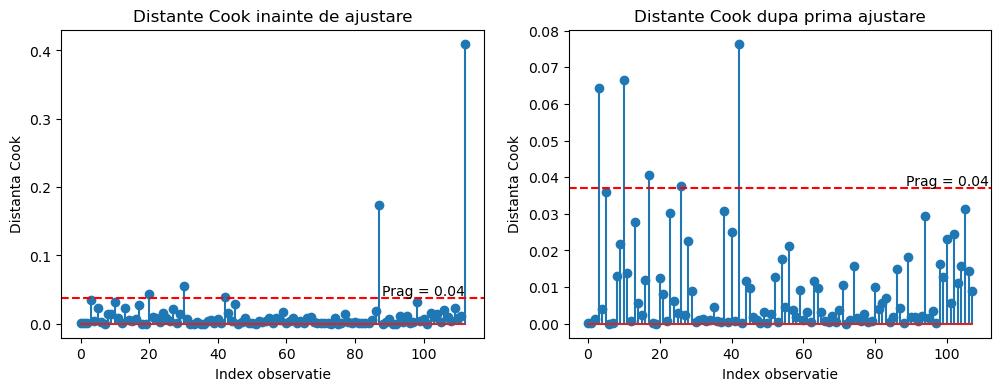

jarque_bera
(6.095638131342836, 0.04746232380779422, -0.5521904938604308, 3.36732667391603)
SHAPIRO
ShapiroResult(statistic=0.9790853261947632, pvalue=0.08685064315795898)
Kolmogov Smirnov
KstestResult(statistic=0.06893487707270651, pvalue=0.6579748348641272, statistic_location=0.1072700675164624, statistic_sign=-1)


In [ ]:
influence = regresie.get_influence()
cooks_d, p_values = influence.cooks_distance
df_with_cook = df_train.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
df_with_cook.drop(index=influential.index,inplace=True)

figura, axe = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1,ax2 = axe

ax1.stem(cooks_d)
ax1.set_xlabel('Index observatie')
ax1.set_ylabel("Distanta Cook")
ax1.set_title("Distante Cook inainte de ajustare")
ax1.axhline(4 / len(df_with_cook),linestyle="--",color='red')
ax1.text(100,
         4 / len(df_with_cook),
        f"Prag = {np.round(4 / len(df_with_cook),2)}",
        va="bottom",
        ha="center"
        )
regresie_cook = smf.ols('happy ~ GDP_capita_logged +Freedom + I(Social_support**3) + South_America',data=df_with_cook).fit()
# exog = regresie_cook.model.exog
# fit = regresie_cook.fittedvalues


influence = regresie_cook.get_influence()
cooks_d, p_values = influence.cooks_distance
# df_with_cook = df.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
# df_with_cook.drop(index=influential.index,inplace=True)
ax2.stem(cooks_d)
ax2.set_xlabel('Index observatie')
ax2.set_ylabel("Distanta Cook")
ax2.set_title("Distante Cook dupa prima ajustare")
ax2.axhline(4 / len(df_with_cook),linestyle="--",color="red")
ax2.text(100,
         4 / len(df_with_cook),
        f"Prag = {np.round(4 / len(df_with_cook),2)}",
        va="bottom",
        ha="center"
        )

plt.show()

testare_normalitate(regresie=regresie_cook,bins=10,afiseaza_grafic=False)
print("---------------------------")
testare_homoschedasticitate(regression=regresie_cook,actual=df_with_cook['happy'],afiseaza_grafic=False)

Testul White
(12.978035491892188, 0.4495097113619103, 0.9872235278702521, 0.47012567216260215)
Test Breuche-Pagan
(7.034420167439234, 0.13408041882472646, 1.7951254357556528, 0.13572892244928006)


In [41]:
state = random.getstate()

In [13]:
# testare_normalitate(regresie=regresie_cook,bins=15,afiseaza_grafic=False)

In [ ]:
print("\nDURBIN WATSON AUTOCORELARE: "+str(durbin_watson(regresie_cook.resid)))

In [ ]:
vif = {k:variance_inflation_factor(exog,i) for k,i in zip(regresie_cook.params.index,range(len(regresie_cook.params.index)))}
vif

In [ ]:
regresie_cook = smf.ols('happy ~ GDP_capita_logged +Freedom + I(Social_support**3) + South_America',data=df_with_cook).fit()
reset = linear_reset(regresie_cook, power=2, use_f=True)
print(regresie_cook.summary())
print(reset)

In [ ]:
# X = df_with_cook[["Social_support","Freedom","Asia","South_America","Life_expectancy"]].copy(deep=True)
# X['Freedom_2'] = np.power(X['Freedom'],2)
# X['Freedom_3'] = np.power(X['Freedom'],3)
# X['Freedom_4'] = np.power(X['Freedom'],4)
# X['Freedom_5'] = np.power(X['Freedom'],5)
# X['Freedom_6'] = np.power(X['Freedom'],6)


In [ ]:
scaler = StandardScaler()
X = df_with_cook[['Social_support','GDP_capita_logged','Freedom','South_America']].copy()
X['Freedom'] = X['Freedom']**3
X =X.to_numpy()
y = df_with_cook['happy'].to_numpy()
X_cook_scaled_train = scaler.fit_transform(X)
# y_cook_scaled_train = scaler.fit_transform(y)
y_cook_scaled_train = (y - np.mean(y))/ np.std(y)
X_scaled_test = scaler.fit_transform(df_test[['Social_support','GDP_capita_logged','Freedom','South_America']])
y_scaled_test = (df_test['happy'] - df_test['happy'].mean())/df_test['happy'].std()
r2_testData = r2_score(df_test['happy'],regresie_cook.predict(df_test[['Social_support','GDP_capita_logged','Freedom','South_America']]))

Ridge

In [ ]:
ridge = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])
ridge.fit(X_cook_scaled_train, y_cook_scaled_train)
ridge_coef = ridge.coef_
ridge_r2 = ridge.score(X_scaled_test, y_scaled_test)
print(f"Ridge R-squared {ridge_r2}")
print("Orifinal R-squared: "+ str(r2_testData))

Lasso

In [ ]:
lasso = LassoCV(
    alphas=None,
    cv=5,
    random_state=42,
    max_iter=10000
)
lasso.fit(X_cook_scaled_train, y_cook_scaled_train)

lasso_coef = lasso.coef_
lasso_r2 = lasso.score(X_scaled_test, y_scaled_test)
print(f"Lasso R-squared {lasso_r2}")
print("Original R-squared: "+ str(r2_testData))

Elastic Net

In [ ]:
elastic = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    alphas=None,
    cv=5,
    random_state=42,
    max_iter=10000
)
elastic.fit(X_cook_scaled_train, y_cook_scaled_train)

elastic_coef = elastic.coef_
elastic_r2 = elastic.score(X_scaled_test, y_scaled_test)
print(f"Elastic R-squared {elastic_r2}")
print("Original R-squared: "+ str(r2_testData))

In [ ]:
parametrii = ['Social_support','GDP_capita_logged','Freedom','South_America']
X = df_test[parametrii].copy()
X['Freedom'] = X['Freedom']**3
parametrii.append('happy')
parametrii.append('Region_2')
parametrii.append('cluster')
real = df_test['happy']
rezultate_regresie = df_test[parametrii].copy()
rezultate_regresie.rename(columns={'happy':'Actual'},inplace=True)
rezultate_regresie['predicted'] = regresie_cook.predict(X)
estimat = rezultate_regresie['predicted']

In [ ]:
RMSE = np.sqrt(np.mean(np.power(real -estimat,2)))
print("RMSE: "+ str(RMSE))
MSE = np.mean(np.power(real-estimat,2))
print("MSE: "+ str(MSE))

r2_testData = r2_score(real,estimat)
print("R-squared: "+ str(r2_testData))

MAE = mean_absolute_error(real, estimat)
print("MAE: "+ str(MAE))

conditie = real != 0
# mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
mape = np.mean(np.abs(real[conditie] - estimat[conditie]) / estimat[conditie]) * 100
print("MAPE: "+ str(np.round(mape,2))+"%")


plt.figure(figsize=(10,6))
sns.scatterplot(x='Actual',y='predicted',hue='cluster',data=rezultate_regresie)
plt.xlabel("Real")
plt.ylabel("Estimat")
plt.title("Real vs Estimat")
x = np.linspace(3, 7, 100)
plt.plot(x, x,color='red')
plt.text(8,8,f"45 \N{DEGREE SIGN} perfect match",color='red')
plt.show()